## Libraries

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from stop_words import get_stop_words
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer  # noqa: E501
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dnguy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## EDA

In [23]:
df = pd.read_csv('reviews.csv')
df.head()

,hotel_name,processed_review,date_stayed,trip_type,processed_rating
0,Fairmont Austin,great service and food sebastian was our serve...,August 2023,with family,50
1,Fairmont Austin,the gold level service was incredible i hate w...,February 2023,with family,50
2,Fairmont Austin,fantastic experience over batfest weekend firs...,August 2023,as a couple,50
3,Fairmont Austin,excellent service great amenities my husband a...,August 2023,on business,50
4,Fairmont Austin,fabulous feet from awesome pedicure i had a pe...,August 2023,on business,50


##### Create new column "rating" based on 50 to 5.0, and so on
##### Creating new column "churn" based on if "processed_rating" is > 35

In [24]:
df['rating'] = df['processed_rating']/10
df['churn'] = df['rating'].apply(lambda x: 0 if x > 3.5 else 1)
df.head()

,hotel_name,processed_review,date_stayed,trip_type,processed_rating,rating,churn
0,Fairmont Austin,great service and food sebastian was our serve...,August 2023,with family,50,5.0,0
1,Fairmont Austin,the gold level service was incredible i hate w...,February 2023,with family,50,5.0,0
2,Fairmont Austin,fantastic experience over batfest weekend firs...,August 2023,as a couple,50,5.0,0
3,Fairmont Austin,excellent service great amenities my husband a...,August 2023,on business,50,5.0,0
4,Fairmont Austin,fabulous feet from awesome pedicure i had a pe...,August 2023,on business,50,5.0,0


Text(0.5, 1.0, 'Review Count by Rating')

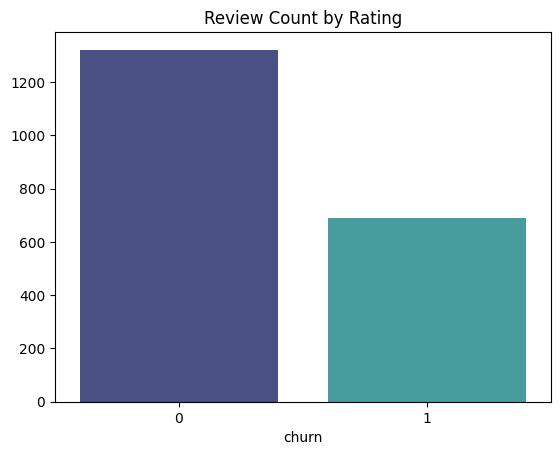

In [25]:
grouped = df.groupby('churn')['churn'].count()
sns.barplot(x = grouped.index, y = grouped.values, palette='mako').set_title('Review Count by Rating')

## Duplicate Removal
No two reviews are the same.

In [26]:
np.unique(df['processed_review'].duplicated(keep='first'))


array([False])

In [27]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Missing Values
Since date_stayed is only used in visualizations and not our models, it can be ignored.

In [28]:
df.columns[df.isnull().any()]

Index(['date_stayed'], dtype='object')

## Tokenize "processed_review"

In [29]:
len(get_stop_words('en'))

174

In [30]:
len(stopwords.words('english'))

179

In [31]:
sw = stopwords.words('english')

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def doc_preparer(doc, stop_words=sw):
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

df['tokenized_review'] = df['processed_review'].apply(doc_preparer)

## Pre-modeling - Train Test Split

In [32]:
X = df['tokenized_review']
y = df['churn']

X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .7, random_state= 760397, stratify = y)

## Vectorizing
Cutting off the top 10% and bottom 5% of words in vectorized documents to keep the more meaningful words.

In [33]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, max_df=.9, min_df=.05,  ngram_range=(1, 1))
train_features = tfidf_train.fit_transform(X_train).toarray()
test_features = tfidf_train.transform(X_test).toarray()

# wm = tfidf_train.fit_transform(X_train)
# tokens = tfidf_train.get_feature_names_out()

# wm.shape
# doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
# data = pd.DataFrame(data=wm.toarray(), index=doc_names,
#                   columns=tokens)
# data.mean().sort_values()

## PCA

In [34]:
scaler = MinMaxScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.fit_transform(test_features)

pca = PCA(random_state=760397)

pca_train = pca.fit_transform(scaled_train_features)
pca_test = pca.transform(scaled_test_features)

## Modeling

##### Evaluation Function

In [35]:
def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")

## Logistic Regression

In [99]:
pipe = Pipeline(steps=[('LR', linear_model.LogisticRegression(random_state=760397))])

params = dict(LR__C=np.logspace(0, 1, 10),
              LR__penalty=['l2', 'none'],
              LR__class_weight=[{0: 1, 1: w} for w in [1, 2, 5, 10, 20]])

LR_grid_search = GridSearchCV(estimator = pipe,
                                  scoring = make_scorer(f1_score, average='weighted'), 
                                  param_grid = params, 
                                  cv = 5, n_jobs = -1, verbose = 2)

LR_grid_search.fit(train_features, y_train)
# LR_PCA_train_preds = LR_PCA_grid_search.best_estimator_.predict(pca_train)
LR_test_preds = LR_grid_search.best_estimator_.predict(test_features)
# metrics_score(LR_PCA_train_preds, y_train, LR_PCA_test_preds, y_test)
print("Best params: " + str(LR_grid_search.best_params_))

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, LR_test_preds).ravel()
print("True Negatives: ", tn, 
      "\nFalse Positives: ", fp, 
      "\nFalse Negatives: ", fn, 
      "\nTrue Positives: ", tp)
# sns.heatmap(confusion_matrix(y_test, LR_PCA_test_preds).T,
#             square=True,
#             annot=True,
#             fmt='d',
#             cmap="rocket_r",
#             linewidths=1).set_title('Confusion Matrix', fontsize=30)

# Classification Report
print(classification_report(y_test, LR_test_preds))

# # FEATURE IMPORTANCE
# # Fit the TfidfVectorizer separately
# tfidf_vectorizer = tfidf_train
# train_features_tfidf = tfidf_vectorizer.fit_transform(X_train)
# test_features_tfidf = tfidf_vectorizer.transform(X_test)

# # Fit the optimal logistic regression model
# logistic_pipe = linear_model.LogisticRegression(C=LR_grid_search.best_params_['LR__C'],
#                                                 max_iter=LR_grid_search.best_params_['LR__max_iter'],
#                                                 penalty=LR_grid_search.best_params_['LR__penalty'],
#                                                 class_weight='balanced',
#                                                 random_state=760397)
# lr_model = logistic_pipe.fit(train_features_tfidf, y_train)

# # Get the coefficients of the LR model
# lr_coefficients = lr_model.coef_[0]

# # Get the feature names from the TfidfVectorizer
# feature_names = tfidf_vectorizer.get_feature_names_out()

# # Create a DataFrame to store feature names and their corresponding coefficients
# feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})

# # Sort the DataFrame by coefficient magnitude to get feature importance
# sorted_feature_importance = feature_importance_df.sort_values(by='Coefficient', ascending=False)

# # Print the top feature importance values along with the corresponding words
# print("Top 5 POSITIVE Features by Importance:")
# for index, row in sorted_feature_importance.head(5).iterrows():
#     feature_word = row['Feature']
#     coefficient = row['Coefficient']
#     print(f"Word: {feature_word}\tCoefficient: {coefficient}")

# print('\n')

# print("Top 5 NEGATIVE Features by Importance:")
# for index, row in sorted_feature_importance.tail(5).iterrows():
#     feature_word = row['Feature']
#     coefficient = row['Coefficient']
#     print(f"Word: {feature_word}\tCoefficient: {coefficient}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'LR__C': 1.6681005372000588, 'LR__class_weight': {0: 1, 1: 1}, 'LR__penalty': 'l2'}
True Negatives:  358 
False Positives:  39 
False Negatives:  44 
True Positives:  163
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       397
           1       0.81      0.79      0.80       207

    accuracy                           0.86       604
   macro avg       0.85      0.84      0.85       604
weighted avg       0.86      0.86      0.86       604



## Logistic Regression (PCA)

In [100]:
pipe = Pipeline(steps=[('LR', linear_model.LogisticRegression(random_state=760397))])

params = dict(LR__C=np.logspace(0, 1, 10),
              LR__penalty=['none', 'l2'],
              LR__class_weight=[{1:1, 0:1}, 
                                {1:1, 0:2}, 
                                {1:1, 0:3}])

LR_PCA_grid_search = GridSearchCV(estimator = pipe,
                                  scoring = make_scorer(f1_score, average='weighted'), 
                                  param_grid = params, 
                                  cv = 5, n_jobs = -1, verbose = 2)

LR_PCA_grid_search.fit(pca_train, y_train)
# LR_PCA_train_preds = LR_PCA_grid_search.best_estimator_.predict(pca_train)
LR_PCA_test_preds = LR_PCA_grid_search.best_estimator_.predict(pca_test)
# metrics_score(LR_PCA_train_preds, y_train, LR_PCA_test_preds, y_test)
print("Best params: " + str(LR_PCA_grid_search.best_params_))

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, LR_PCA_test_preds).ravel()
print("True Negatives: ", tn, 
      "\nFalse Positives: ", fp, 
      "\nFalse Negatives: ", fn, 
      "\nTrue Positives: ", tp)
# sns.heatmap(confusion_matrix(y_test, LR_PCA_test_preds).T,
#             square=True,
#             annot=True,
#             fmt='d',
#             cmap="rocket_r",
#             linewidths=1).set_title('Confusion Matrix', fontsize=30)

# Classification Report
print(classification_report(y_test, LR_PCA_test_preds))

# # FEATURE IMPORTANCE
# # Fit the TfidfVectorizer separately
# tfidf_vectorizer = tfidf_train
# train_features_tfidf = tfidf_vectorizer.fit_transform(X_train)
# test_features_tfidf = tfidf_vectorizer.transform(X_test)

# # Fit the optimal logistic regression model
# logistic_pipe = linear_model.LogisticRegression(C=LR_PCA_grid_search.best_params_['LR__C'],
#                                                 max_iter=LR_PCA_grid_search.best_params_['LR__max_iter'],
#                                                 penalty=LR_PCA_grid_search.best_params_['LR__penalty'],
#                                                 class_weight='balanced',
#                                                 random_state=760397)
# lr_model = logistic_pipe.fit(train_features_tfidf, y_train)

# # Get the coefficients of the LR model
# lr_coefficients = lr_model.coef_[0]

# # Get the feature names from the TfidfVectorizer
# feature_names = tfidf_vectorizer.get_feature_names_out()

# # Create a DataFrame to store feature names and their corresponding coefficients
# feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})

# # Sort the DataFrame by coefficient magnitude to get feature importance
# sorted_feature_importance = feature_importance_df.sort_values(by='Coefficient', ascending=False)

# # Print the top feature importance values along with the corresponding words
# print("Top 5 POSITIVE Features by Importance:")
# for index, row in sorted_feature_importance.head(5).iterrows():
#     feature_word = row['Feature']
#     coefficient = row['Coefficient']
#     print(f"Word: {feature_word}\tCoefficient: {coefficient}")

# print('\n')

# print("Top 5 NEGATIVE Features by Importance:")
# for index, row in sorted_feature_importance.tail(5).iterrows():
#     feature_word = row['Feature']
#     coefficient = row['Coefficient']
#     print(f"Word: {feature_word}\tCoefficient: {coefficient}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params: {'LR__C': 1.0, 'LR__class_weight': {1: 1, 0: 1}, 'LR__penalty': 'l2'}
True Negatives:  354 
False Positives:  43 
False Negatives:  52 
True Positives:  155
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       397
           1       0.78      0.75      0.77       207

    accuracy                           0.84       604
   macro avg       0.83      0.82      0.82       604
weighted avg       0.84      0.84      0.84       604



## Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=760397)

pipe = Pipeline(steps=[
    ('RF', rf_classifier)
])

params = {
    # 1st CV
    # 'RF__max_features':['sqrt', 'log2', None],
    # 'RF__n_estimators': [300, 500, 700, 900, 1100, 1300]
    
    # 2nd CV
    # 'RF__max_features':['log2'],
    # 'RF__n_estimators': [400, 500, 600],
    # 'RF__criterion': ['entropy', 'gini'],
    # 'RF__max_depth': [7, 9, 11, 13, 15, None]

    # 3rd CV
    # 'RF__max_features':['log2'],
    # 'RF__n_estimators': [550, 600, 650],
    # 'RF__criterion': ['entropy'],
    # 'RF__max_depth': [None]

    # 4th CV
    # 'RF__max_features':['log2'],
    # 'RF__n_estimators': [600],
    # 'RF__criterion': ['entropy'],
    # 'RF__max_depth': [None],
    # 'RF__min_samples_leaf': [1, 3, 5, 7],
    # 'RF__min_samples_split': [2, 4, 6, 8]

    # 5th CV
    'RF__max_features':['log2'],
    'RF__n_estimators': [600],
    'RF__criterion': ['entropy'],
    'RF__max_depth': [None],
    'RF__min_samples_leaf': [1],
    'RF__min_samples_split': [8],
    'RF__class_weight':[{1:1, 0:1}, 
                        {1:1, 0:2}, 
                        {1:1, 0:3}]
}

RF_grid_search = GridSearchCV(
    estimator=pipe,
    scoring=make_scorer(f1_score, average='weighted'),
    param_grid=params,
    cv=5, n_jobs=-1, verbose=2
)

RF_grid_search.fit(train_features, y_train)
RF_train_preds = RF_grid_search.best_estimator_.predict(train_features)
RF_test_preds = RF_grid_search.best_estimator_.predict(test_features)

print('\n')
# metrics_score(RF_PCA_train_preds, y_train, RF_PCA_test_preds, y_test)
print("Best params: " + str(RF_grid_search.best_params_))
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, RF_test_preds).ravel()
print("True Negatives: ", tn, 
      "\nFalse Positives: ", fp, 
      "\nFalse Negatives: ", fn, 
      "\nTrue Positives: ", tp)
print(classification_report(y_test, RF_test_preds))

# # FEATURE IMPORTANCE
# # Fit the optimal logistic regression model
# RF_pipe = RandomForestClassifier(class_weight=RF_PCA_grid_search.best_params_['RF__class_weight'],
#                                  criterion=RF_PCA_grid_search.best_params_['RF__criterion'],
#                                  max_depth=RF_PCA_grid_search.best_params_['RF__max_depth'],
#                                  max_features=RF_PCA_grid_search.best_params_['RF__max_features'],
#                                  min_samples_leaf=RF_PCA_grid_search.best_params_['RF__min_samples_leaf'],
#                                  min_samples_split=RF_PCA_grid_search.best_params_['RF__min_samples_split'],
#                                  n_estimators=RF_PCA_grid_search.best_params_['RF__n_estimators'],
#                                  n_jobs=-1, random_state=760397)
# RF_model = RF_pipe.fit(train_features_tfidf, y_train)

# # Get the feature importances
# feature_importances = RF_model.feature_importances_

# # Get the feature names from the TfidfVectorizer
# feature_names = tfidf_vectorizer.get_feature_names_out()

# # Create a DataFrame to store feature names and their corresponding importances
# feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# # Sort the DataFrame by importance magnitude to get feature importance
# sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Print the top feature importance values along with the corresponding words
# print("Top 5 POSITIVE Features by Importance:")
# for index, row in sorted_feature_importance.head(5).iterrows():
#     feature_word = row['Feature']
#     importance = row['Importance']
#     print(f"Word: {feature_word}\tImportance: {importance}")

# print("Top 5 NEGATIVE Features by Importance:")
# for index, row in sorted_feature_importance.tail(5).iterrows():
#     feature_word = row['Feature']
#     importance = row['Importance']
#     print(f"Word: {feature_word}\tImportance: {importance}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits


Best params: {'RF__class_weight': {1: 1, 0: 1}, 'RF__criterion': 'entropy', 'RF__max_depth': None, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 8, 'RF__n_estimators': 600}
True Negatives:  371 
False Positives:  26 
False Negatives:  61 
True Positives:  146
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       397
           1       0.85      0.71      0.77       207

    accuracy                           0.86       604
   macro avg       0.85      0.82      0.83       604
weighted avg       0.86      0.86      0.85       604



## Decision Tree

In [111]:
dt_classifier = DecisionTreeClassifier(random_state=760397)

pipe = Pipeline(steps=[
    ('DT', dt_classifier)
])

params = {
    # 1st CV
    # 'DT__max_features':['auto', 'sqrt', 'log2', None],
    # 'DT__max_leaf_nodes': [i for i in range(2, 21)]
    
    # 2nd CV
    # 'DT__max_features':[None],
    # 'DT__max_leaf_nodes': [18],
    # 'DT__criterion': ['entropy', 'gini'],
    # 'DT__max_depth': [1, 3, 5, 7, 9, 11, 13, 15, None]

    # 3rd CV
    # 'DT__max_features':[None],
    # 'DT__max_leaf_nodes': [18],
    # 'DT__criterion': ['entropy'],
    # 'DT__max_depth': [12, 13, 14]

    # 4th CV
    # 'DT__max_features':[None],
    # 'DT__max_leaf_nodes': [18],
    # 'DT__criterion': ['entropy'],
    # 'DT__max_depth': [13],
    # 'DT__min_samples_leaf': [1, 3, 5, 7],
    # 'DT__min_samples_split': [2, 4, 6, 8]

    # 5th CV
    'DT__max_features':[None],
    'DT__max_leaf_nodes': [18],
    'DT__criterion': ['entropy'],
    'DT__max_depth': [13],
    'DT__min_samples_leaf': [1],
    'DT__min_samples_split': [2],
    'DT__class_weight':[{1:1, 0:1}, 
                        {1:1, 0:2}, 
                        {1:1, 0:3}]
}

DT_grid_search = GridSearchCV(
    estimator=pipe,
    scoring=make_scorer(f1_score, average='weighted'),
    param_grid=params,
    cv=5, n_jobs=-1, verbose=2
)

DT_grid_search.fit(train_features, y_train)
DT_train_preds = DT_grid_search.best_estimator_.predict(train_features)
DT_test_preds = DT_grid_search.best_estimator_.predict(test_features)

print('\n')
# metrics_score(RF_PCA_train_preds, y_train, RF_PCA_test_preds, y_test)
print("Best params: " + str(DT_grid_search.best_params_))
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, DT_test_preds).ravel()
print("True Negatives: ", tn, 
      "\nFalse Positives: ", fp, 
      "\nFalse Negatives: ", fn, 
      "\nTrue Positives: ", tp)
print(classification_report(y_test, DT_test_preds))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Best params: {'DT__class_weight': {1: 1, 0: 1}, 'DT__criterion': 'entropy', 'DT__max_depth': 13, 'DT__max_features': None, 'DT__max_leaf_nodes': 18, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}
True Negatives:  339 
False Positives:  58 
False Negatives:  73 
True Positives:  134
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       397
           1       0.70      0.65      0.67       207

    accuracy                           0.78       604
   macro avg       0.76      0.75      0.75       604
weighted avg       0.78      0.78      0.78       604



## Decision Tree (PCA)

In [120]:
dt_classifier = DecisionTreeClassifier(random_state=760397)

pipe = Pipeline(steps=[
    ('DT', dt_classifier)
])

params = {
    # 1st CV
    # 'DT__max_features':['auto', 'sqrt', 'log2', None],
    # 'DT__max_leaf_nodes': [i for i in range(2, 21)]
    
    # 2nd CV
    # 'DT__max_features':[None],
    # 'DT__max_leaf_nodes': [2],
    # 'DT__criterion': ['entropy', 'gini'],
    # 'DT__max_depth': [1, 3, 5, 7, 9, 11, 13, 15, None]

    # 3rd CV
    # 'DT__max_features':[None],
    # 'DT__max_leaf_nodes': [2],
    # 'DT__criterion': ['gini'],
    # 'DT__max_depth': [1]

    # 4th CV
    # 'DT__max_features':[None],
    # 'DT__max_leaf_nodes': [2],
    # 'DT__criterion': ['gini'],
    # 'DT__max_depth': [1],
    # 'DT__min_samples_leaf': [1, 3, 5, 7],
    # 'DT__min_samples_split': [2, 4, 6, 8]

    # 5th CV
    'DT__max_features':[None],
    'DT__max_leaf_nodes': [2],
    'DT__criterion': ['gini'],
    'DT__max_depth': [1],
    'DT__min_samples_leaf': [1],
    'DT__min_samples_split': [2],
    'DT__class_weight':[{1:1, 0:1}, 
                        {1:1, 0:2}, 
                        {1:1, 0:3}]
}

DT_PCA_grid_search = GridSearchCV(
    estimator=pipe,
    scoring=make_scorer(f1_score, average='weighted'),
    param_grid=params,
    cv=5, n_jobs=-1, verbose=2
)

DT_PCA_grid_search.fit(pca_train, y_train)
DT_PCA_train_preds = DT_PCA_grid_search.best_estimator_.predict(pca_train)
DT_PCA_test_preds = DT_PCA_grid_search.best_estimator_.predict(pca_test)

print('\n')
# metrics_score(RF_PCA_train_preds, y_train, RF_PCA_test_preds, y_test)
print("Best params: " + str(DT_PCA_grid_search.best_params_))
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, DT_PCA_test_preds).ravel()
print("True Negatives: ", tn, 
      "\nFalse Positives: ", fp, 
      "\nFalse Negatives: ", fn, 
      "\nTrue Positives: ", tp)
print(classification_report(y_test, DT_PCA_test_preds))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Best params: {'DT__class_weight': {1: 1, 0: 2}, 'DT__criterion': 'gini', 'DT__max_depth': 1, 'DT__max_features': None, 'DT__max_leaf_nodes': 2, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}
True Negatives:  347 
False Positives:  50 
False Negatives:  62 
True Positives:  145
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       397
           1       0.74      0.70      0.72       207

    accuracy                           0.81       604
   macro avg       0.80      0.79      0.79       604
weighted avg       0.81      0.81      0.81       604



## ROC Curve (doesn't make sense for binary classification)

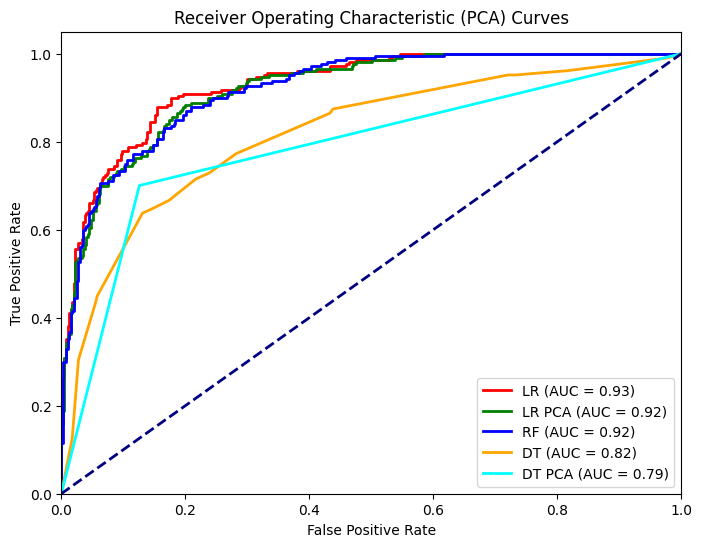

In [69]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Logistic Regression ROC curve
LR_model_predictions = LR_grid_search.best_estimator_.predict_proba(test_features)[:, 1]
LR_fpr, LR_tpr, _ = roc_curve(y_test, LR_model_predictions)
LR_roc_auc = auc(LR_fpr, LR_tpr)

# Logistic Regression (PCA) ROC curve
LR_PCA_model_predictions = LR_PCA_grid_search.best_estimator_.predict_proba(pca_test)[:, 1]
LR_PCA_fpr, LR_PCA_tpr, _ = roc_curve(y_test, LR_PCA_model_predictions)
LR_PCA_roc_auc = auc(LR_PCA_fpr, LR_PCA_tpr)

# Random Forest ROC curve
RF_model_predictions = RF_grid_search.best_estimator_.predict_proba(test_features)[:, 1]
RF_fpr, RF_tpr, _ = roc_curve(y_test, RF_model_predictions)
RF_roc_auc = auc(RF_fpr, RF_tpr)

# Decision Tree ROC curve
DT_model_predictions = DT_grid_search.best_estimator_.predict_proba(test_features)[:, 1]
DT_fpr, DT_tpr, _ = roc_curve(y_test, DT_model_predictions)
DT_roc_auc = auc(DT_fpr, DT_tpr)

# Decision Tree (PCA) ROC curve
DT_PCA_model_predictions = DT_PCA_grid_search.best_estimator_.predict_proba(pca_test)[:, 1]
DT_PCA_fpr, DT_PCA_tpr, _ = roc_curve(y_test, DT_PCA_model_predictions)
DT_PCA_roc_auc = auc(DT_PCA_fpr, DT_PCA_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(LR_fpr, LR_tpr, color='red', lw=2, label='LR (AUC = %0.2f)' % LR_roc_auc)
plt.plot(LR_PCA_fpr, LR_PCA_tpr, color='green', lw=2, label='LR PCA (AUC = %0.2f)' % LR_PCA_roc_auc)
plt.plot(RF_fpr, RF_tpr, color='blue', lw=2, label='RF (AUC = %0.2f)' % RF_roc_auc)
plt.plot(DT_fpr, DT_tpr, color='orange', lw=2, label='DT (AUC = %0.2f)' % DT_roc_auc)
plt.plot(DT_PCA_fpr, DT_PCA_tpr, color='cyan', lw=2, label='DT PCA (AUC = %0.2f)' % DT_PCA_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (PCA) Curves')
plt.legend(loc="lower right", alignment='right')
plt.show()

## Predicting A New Review

In [42]:
# 3rd entry of reviews.csv
title = "The Gold level service was incredible"
review = "I hate writing reviews but this experience was so good I couldn't not. A big reason is that we left something in the room at check out and the staff found it and has kept it for us. We booked to stay for seven nights in a one bedroom with our two young daughters on the gold level which was the best idea. From the doorman who shuttled us to the gold level where we were able to check in while the kids enjoyed refreshments after a long travel day to the staff in the lunch itself who revealed a games cabinet. We loved it so much (and it was snowing back home) we stayed another four nights in the Grand Suite which was even better. It was huge and came with its own kitchen! Without going to long, the pool was always warm, the drinks were always cold, and the staff was always…"
# non-churn

In [43]:
# Random 1 star review
title = "Worst hotel ever!!"
review = "Horrible experience. Horrible. Upon walking into the room it was hot, sticky and smelled bad-musty. There were two hard, crusty stains on the carpet that they had hardly even tried to clean up, the carpet overall was dirty. The shower leaked and the toilet sounded like a screaming jet engine. They have absolutely no channels on the tv. Their WiFi was trash. The pillows, sheets and comforter smelled old and like someone else’s sweat. They advertise and tell you at check in that they have in room services such as food but they do not. We couldn’t even get bottled water, which was horrid after being on a plane for 10 hours to get there —-we were thirsty. The walls are paper thin so you hear everything including people yelling all night. The rooms are not clean, there is an inch…"
# churn

In [44]:
# Chat-GPT POSITIVE review using negative words (new chat)
title = """An Unforgettable Hotel Experience: Love It or... "Love" It More?"""
review = """Let me tell you about my recent stay at this hotel, which was an experience I won't soon forget. From the moment I arrived, I was greeted with a level of "uniqueness" that I can only describe as "hatefully unforgettable."

Let's delve into the rooms, shall we? The term "cozy" takes on a whole new meaning here. It's like they've redefined the concept of personal space to mean "nonexistent." If you're someone who "loves" the idea of having to navigate around furniture with the precision of a tightrope walker, then you're in for a treat.

The staff – oh, where do I begin with them? Their "enthusiasm" is truly something to behold, especially if you have a passion for witnessing people who take customer service to a whole new level of "uncontainable enthusiasm." It's almost as if they're on a mission to make you question your own sanity.

And let's not forget the dining experience. The menu is a masterclass in "unconventional" culinary choices. Each dish seems to be an experiment in combining ingredients that were never meant to meet. If you've ever "hated" the idea of a meal making logical sense, this place will reaffirm your beliefs.

As for the hotel's interior design, it's a "worse" version of eclectic. The clash of "vintage" and "modern" elements creates an atmosphere that can only be described as "hatefully fascinating." It's like someone picked out pieces from various time periods blindfolded and hoped for the best.

In conclusion, if you're the type of person who relishes in the idea of an experience that you'll "love" to recount as the epitome of the word "unique," then this hotel should be at the top of your list. It's a "worse" nightmare for those who appreciate the conventional, and a "hateful" dream for those who live for the offbeat."""
# churn


In [45]:
# Chat-GPT NEGATIVE review using positive words (new chat2)
title = "Absolutely loved my stay at this hotel."
review = "The incredible attention to detail was mind-boggling - from the exquisitely clean and spacious room to the overly friendly and accommodating staff who just wouldn't give me a moment of peace. And let's not forget the endless array of amenities that made me feel like I was drowning in luxury. The breathtaking view from my window was such a distraction that I couldn't even concentrate on my work. And the food? Oh, don't even get me started on the gourmet meals that left me in a state of constant overindulgence. I must say, I was utterly overwhelmed by the constant pampering and care. Can't wait to never stay here again!"
# churn (false positive but this text from Chat-GPT is weird)

In [46]:
# 2nd Chat-GPT POSITIVE review using negative words (used chat2)
title = "I must admit, my stay at this hotel was quite the experience."
review = "The room I was assigned was a real masterpiece of inconvenience and discomfort. The bed felt like a slab of concrete designed to challenge my ability to sleep, and the lack of air conditioning turned the room into a cozy sauna, perfect for a hot yoga session. The staff, bless their hearts, were always available to chat, making it nearly impossible for me to have a moment of solitude. The view from my window showcased the bustling construction site next door, providing a constant reminder of urban chaos. And the food? Well, let's just say that my taste buds were treated to a symphony of unique flavors that I won't soon forget – mostly because they were all so incredibly unappetizing. Despite these minor setbacks, I truly appreciated the hotel's commitment to providing an unforgettable and character-building stay."
# non-churn

In [47]:
# 3rd Chat-GPT POSITIVE review using negative words (new chat3)
title = """A Diamond in the Rough"""
review = """I recently had the opportunity to stay at this hotel, and I must admit, I was initially taken aback by some minor aspects. However, as my stay progressed, I realized that there's much more to this place than meets the eye.

While the check-in process seemed a bit slow due to a sudden influx of guests, the staff managed to handle the situation with remarkable poise and professionalism. Despite a momentary inconvenience, their attentive demeanor turned my initial frustration into admiration for their dedication to ensuring a smooth experience for everyone.

The room I was assigned had a quaint charm to it, although it appeared to be in need of a little updating. But what truly caught my attention was the impeccable cleanliness – it was evident that the housekeeping team took their responsibilities seriously. Although the view from the window was less than spectacular, I found solace in the serenity and comfort that the room provided.

The dining experience had its hiccups, with a limited menu that left me wanting more variety. Nevertheless, the flavors of the dishes served were quite delightful. The restaurant staff, while a bit overwhelmed, managed to provide a warm and welcoming atmosphere that made me feel right at home.

One area that could use improvement is the spa facilities. The offerings were somewhat underwhelming, and I had hoped for a more extensive range of treatments. However, the therapists displayed expertise and skill, making the spa visit a rejuvenating experience despite the limited options.

All in all, my stay at this hotel was a valuable lesson in looking beyond initial impressions. The challenges I encountered were overshadowed by the exceptional efforts of the staff, who went above and beyond to ensure my comfort. With a few adjustments, this hotel has the potential to become an absolute gem in the hospitality industry. I left with a sense of gratitude for the positive aspects that shone through the initial setbacks, and I look forward to witnessing the growth of this establishment in the future."""
# non-churn

In [48]:
# 4th Chat-GPT POSITIVE review using negative words (new chat4)
title = ""
review = "I must admit, my initial impression of the hotel wasn't the best due to a minor delay during check-in, which left me slightly frustrated. However, I'm delighted to share that the rest of my stay completely turned things around. The staff went above and beyond to rectify the situation, ensuring that my room was not only spacious and comfortable but also impeccably clean. I was pleasantly surprised by the variety of dining options available, which more than made up for the initial inconvenience. Additionally, the central location of the hotel meant that I had easy access to all the attractions I wanted to visit. While the start might not have been perfect, the exceptional service and overall experience definitely won me over."
# non-churn

In [49]:
title = "Fantastic Experience!"
review = """I had an absolutely wonderful stay at this hotel! The staff was incredibly welcoming and attentive, making me feel right at home from the moment I arrived. The room was spacious, beautifully decorated, and impeccably clean. The comfortable bed ensured a restful night's sleep, and the amenities provided were top-notch.

The location of the hotel was perfect, with easy access to nearby attractions and dining options. What truly stood out was the stunning view from my room – it added an extra layer of magic to my stay.

The hotel's breakfast spread was delicious and offered a great variety of options to suit all tastes. Additionally, the on-site facilities, such as the gym and spa, were well-maintained and enhanced the overall experience.

I can confidently say that this hotel exceeded my expectations in every way. If you're looking for a luxurious and memorable stay, I wholeheartedly recommend this establishment. It's definitely deserving of a 5-star rating!"""

In [50]:
# START ALGORITHM
# Define a list of stop words
stop_words = list(get_stop_words('en'))  # About 900 stopwords
nltk_words = list(stopwords.words('english'))  # About 150 stopwords
punctuations = [".", "'", ","]
stop_words.extend(nltk_words + punctuations)

# Replicating the raw scraped-review text
reviewWithTitle = " ".join((title.strip(), review.strip()))  # noqa: E501

# Replicating the tokenizing
tokenizer = RegexpTokenizer(r'\w+')
word_list = tokenizer.tokenize(reviewWithTitle.lower())
output = [w for w in word_list if not w in stop_words]  # noqa: E501
new_review = ' '.join(word_list)
print(new_review)
# Create blank dataframe for new_review
df2 = pd.DataFrame(['new_review'])
df2['new_review'] = new_review
tokenized_new_review = df2['new_review'].apply(doc_preparer)

# Replicating the vectorizing
new_test_features = tfidf_train.transform(tokenized_new_review).toarray()

# Replicating the pca
new_pca_test = pca.transform(new_test_features)

# Using the optimal LR model to predict our new review
# new_preds = LR_PCA_grid_search.best_estimator_.predict(new_pca_test)
new_preds = LR_PCA_grid_search.best_estimator_.predict(new_pca_test)

# Print prediction
print(new_preds)

fantastic experience i had an absolutely wonderful stay at this hotel the staff was incredibly welcoming and attentive making me feel right at home from the moment i arrived the room was spacious beautifully decorated and impeccably clean the comfortable bed ensured a restful night s sleep and the amenities provided were top notch the location of the hotel was perfect with easy access to nearby attractions and dining options what truly stood out was the stunning view from my room it added an extra layer of magic to my stay the hotel s breakfast spread was delicious and offered a great variety of options to suit all tastes additionally the on site facilities such as the gym and spa were well maintained and enhanced the overall experience i can confidently say that this hotel exceeded my expectations in every way if you re looking for a luxurious and memorable stay i wholeheartedly recommend this establishment it s definitely deserving of a 5 star rating
[0]


## Word Clouds

In [51]:
# Create stopword list:
wc_stopwords = set(STOPWORDS)

# UPDATE THIS WITH WORDS THAT ARE USELESS
wc_stopwords.update(["hotel", "stay", "stayed", "room", "rooms", "staff", "place", "day", "night",  # subject of the reviews 
                     "austin", # city of hotel
                     "s", "u", # random letter words
                     "didn t", "bedtold", "us", "said", "didn", "t", "time", "told", # other words
                     "great", "nice", "good",  # descriptive words
                     "one"]) # numbers

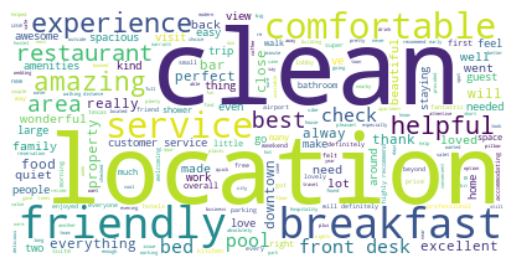

In [53]:
# Non-churn reviews, general manager needs to reply with thankss
# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.churn == 0])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

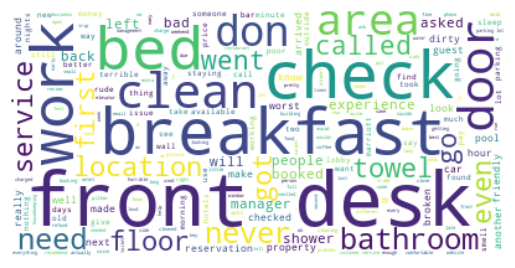

In [54]:
# CHURN REVIEWS
# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.churn == 1])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

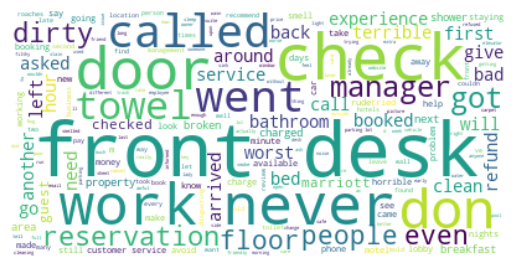

In [55]:
# 1 STAR REVIEWS, customers very likely do not recommend
# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.processed_rating == 10])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

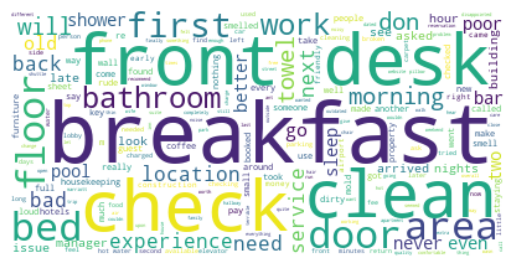

In [56]:
# 2 STAR REVIEWS, customer's majority of experience is negative
# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.processed_rating == 20])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

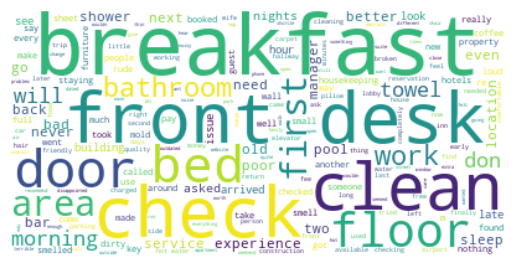

In [57]:
# 3 STAR REVIEWS, customer states hotel is average
# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.processed_rating == 20])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

https://www.datacamp.com/tutorial/wordcloud-python

In [60]:
print(np.unique(df.trip_type))

# Join all reviews of each trip type:
couple_reviews = " ".join(review for review in df[df.trip_type=="as a couple"].processed_review)
business_reviews = " ".join(review for review in df[df.trip_type=="on business"].processed_review)
solo_reviews = " ".join(review for review in df[df.trip_type=="solo"].processed_review)
family_reviews = " ".join(review for review in df[df.trip_type=="with family"].processed_review)
friends_reviews = " ".join(review for review in df[df.trip_type=="with friends"].processed_review)

['as a couple' 'on business' 'solo' 'with family' 'with friends']


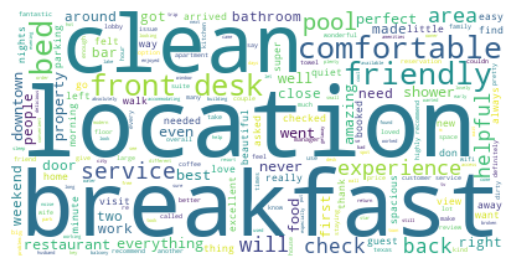

In [61]:
# COUPLE REVIEWS
# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(couple_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

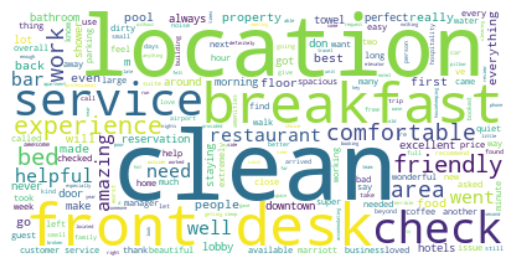

In [62]:
# BUSINESS REVIEWS
# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(business_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

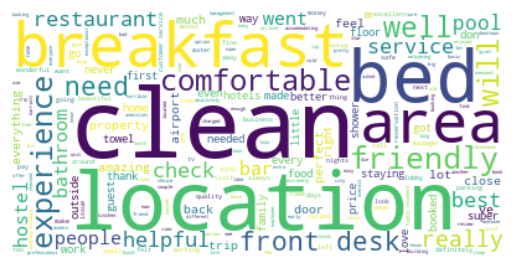

In [63]:
# SOLO REVIEWS
# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(solo_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

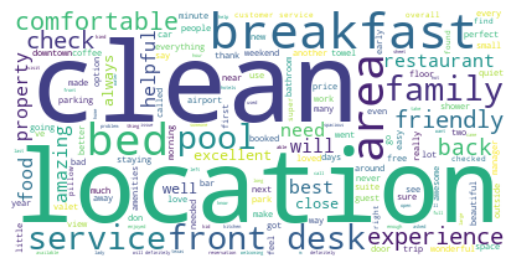

In [64]:
# FAMILY REVIEWS
# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(family_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

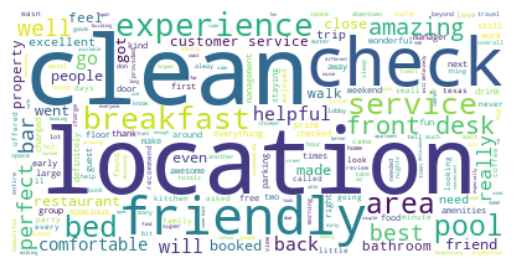

In [65]:
# FRIENDS REVIEWS
# Generate a word cloud image
wordcloud = WordCloud(stopwords=wc_stopwords, background_color="white").generate(friends_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()